# Homework 7
## Alex Pine, 2015-12-12

In [2]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from pystruct.models import ChainCRF
from pystruct.learners import OneSlackSSVM

In [132]:
def read_input(data_dir, dataset_type):
    assert dataset_type == 'train' or dataset_type == 'test', dataset_type
    num_files = 5000 if dataset_type == 'train' else 1000

    X, y = [], []
    sentences = []
    # Iterate over all the training sample files
    for f in [data_dir + "/Data/"+ dataset_type +"-%d.txt" % i 
              for i in range(1, num_files+1)]:
        # Read each training sample file into 'data' variable
        data = pd.read_csv(f, header=None, quoting=3)
        sentences.append(data[0])
        # Extract 'tag' field into 'labels'
        labels = data[1]
        # Extract feature fields into 'features'
        features = data.values[:, 2:].astype(np.int)
        # Adjust features starting at 1 to start at 0
        for f_idx in range(len(features)):
          f1 = features[f_idx]
          features[f_idx] = [f1[0]-1, f1[1], f1[2], f1[3]-1, f1[4]-1]
        # Adjust labels to lie in {0,...,9}, and add to 'y'
        y.append(labels.values - 1)
        # Add feature vector to 'X'
        X.append(features)

    # See: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
    # [Note: if you get an error on the below line, it may be because you need to
    # upgrade scikit-learn]
    encoder = OneHotEncoder(n_values=[1,2,2,201,201],sparse=False).fit(np.vstack(X))                 
    # Represent features using one-of-K scheme: If a feature can take value in 
    # {0,...,K}, then introduce K binary features such that the value of only the 
    # i^th binary feature is non-zero when the feature takes value 'i'.
    # n_values specifies the number of states each feature can take.
    X_encoded = [encoder.transform(x) for x in X]
    return X_encoded, y, sentences

In [133]:
X_train_enc, y_train, train_sentences = read_input('ps7_data', 'train')
X_test_enc, y_test, test_sentences = read_input('ps7_data', 'test')

## Problem 1 Code

In [29]:
# Problem 1: Find the value of the regularization hyperparameter "C" that
# minimizes the loss function of the SSVM.

def split_train_test(X, y, num_train):
    TEST_SET_SIZE = 500
    assert len(X) >= num_train + TEST_SET_SIZE, len(X)
    assert len(y) >= num_train + TEST_SET_SIZE, len(y)
    return X[:num_train], y[:num_train], X[-TEST_SET_SIZE:], y[-TEST_SET_SIZE:]


def train_model(X_train, y_train, X_val, y_val, Cs):
    assert len(X_train) == len(y_train), 'x: %s y: %s' % (len(X_train), len(y_train))
    assert len(X_val) == len(y_val), 'x: %s y: %s' % (len(X_val), len(y_val))

    crf = ChainCRF(n_states=10, inference_method='max-product', directed=True)
    best_model = None
    best_C = None
    smallest_error = None
    print 'training model on data of size', len(X_train)
    for C in Cs:
        print 'training model with C =', C
        ssvm = OneSlackSSVM(crf, max_iter=200, C=C)
        ssvm.fit(X_train, y_train)
        error = 1 - ssvm.score(X_val, y_val) # Note: score 1 - error
        if not smallest_error or error < smallest_error:
            best_model = ssvm
            best_C = C
            smallest_error = error
    return best_model, best_C, smallest_error


def train_models(X, y, num_train_points_list):
    model_tuples = []
    Cs = [0.1, 1.0, 10.0]
    for num_train in num_train_points_list:
        X_train, y_train, X_val, y_val = split_train_test(X, y, num_train)
        model, C, train_error = train_model(X_train, y_train, X_val, y_val, Cs)
        model_tuples.append((model, C, train_error))
    return model_tuples
    
 
def problem_one_find_best_C(X_train, y_train, X_test, y_test):
    model, C, train_error = train_models(X_train, y_train, [4500])[0]
    test_error = 1 - model.score(X_test, y_test)
    return model, C, train_error, test_error


def problem_one_full_model(X_train, y_train, X_test, y_test, best_C):
    model, C, error = train_model(X_train, y_train, X_test, y_test, [best_C])
    return model, error
    

In [30]:
print 'Training first Problem 1 model:'

prob_one_model, best_C, train_error, test_error = problem_one_find_best_C(
    X_train_enc, y_train, X_test_enc, y_test)

Training first Problem 1 model:
training model on data of size 4500
training model with C = 0.1
training model with C = 1.0
training model with C = 10.0


In [31]:
print 'Best C', best_C, ', training error:', train_error, ', validation error:', test_error

Best C 0.1 , training error: 0.116533949824 , validation error: 0.120678322598


In [34]:
prob_one_full_model, full_test_error = problem_one_full_model(
    X_train_enc, y_train, X_test_enc, y_test, best_C)

training model on data of size 5000
training model with C = 0.1


In [36]:
print 'Full model testing error:', full_test_error

Full model testing error: 0.119232286052


## Problem 1 Analysis
I trained the SSVM model on the first 4500 sentences and grid-searched across regulurization parameters of 0.1, 1.0, and 1.0. I found the regularization parameter "C" that minimized the Hamming loss was 0.1, resulting in a Hamming loss of 12.07% on the 500 sentence validation set.

When I retrained the model on all 5000 training sentence using 0.1 for C, it resulted in a Hamming loss of 11.92%


## Question 2 Code

In [57]:
# Question 2

def train_problem_two_models(X_train, y_train, X_test, y_test, 
                             prob_one_num_train, prob_one_model_tuple):
    num_train_points_list = [100, 200, 500, 1000]
    model_tuples = train_models(X_train, y_train, num_train_points_list) 
    num_train_points_list.append(prob_one_num_train)
    model_tuples.append(prob_one_model_tuple)
    
    models = [tup[0] for tup in model_tuples]
    Cs = [tup[1] for tup in model_tuples]
    train_errors = [tup[2] for tup in model_tuples]
    test_errors = [1 - model.score(X_test, y_test) for model in models]
    return models, Cs, num_train_points_list, train_errors, test_errors


In [58]:
prob_one_num_train = 4500
prob_one_model_tuple = prob_one_model, best_C, train_error, test_error

problem_two_model_tuple = train_problem_two_models(
    X_train_enc, y_train, X_test_enc, y_test, prob_one_num_train, prob_one_model_tuple)

models, Cs, num_train_points_list, train_errors, test_errors = problem_two_model_tuple

training model on data of size 100
training model with C = 0.1
training model with C = 1.0
training model with C = 10.0
training model on data of size 200
training model with C = 0.1
training model with C = 1.0
training model with C = 10.0
training model on data of size 500
training model with C = 0.1
training model with C = 1.0
training model with C = 10.0
training model on data of size 1000
training model with C = 0.1
training model with C = 1.0
training model with C = 10.0


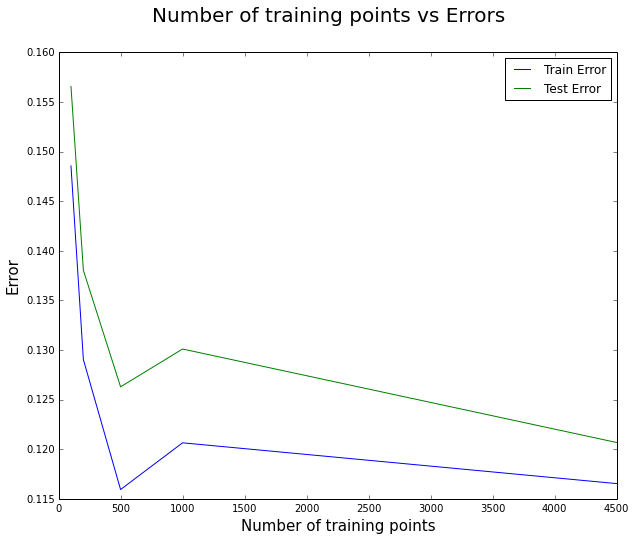

In [60]:
%matplotlib inline

import matplotlib.pyplot as plt

def plot_errors(num_train_points_list, train_errors, test_errors):
    fig = plt.figure(1, figsize=(10, 8))
    fig.suptitle('Number of training points vs Errors', fontsize=20)
    plt.xlabel('Number of training points', fontsize=15)
    plt.ylabel('Error', fontsize=15)
    train_line, = plt.plot(num_train_points_list, train_errors)    
    test_line, = plt.plot(num_train_points_list, test_errors)
    plt.legend([train_line, test_line], 
               ['Train Error', 'Test Error'],
               loc='upper right')
    plt.show()

plot_errors(num_train_points_list, train_errors, test_errors)                

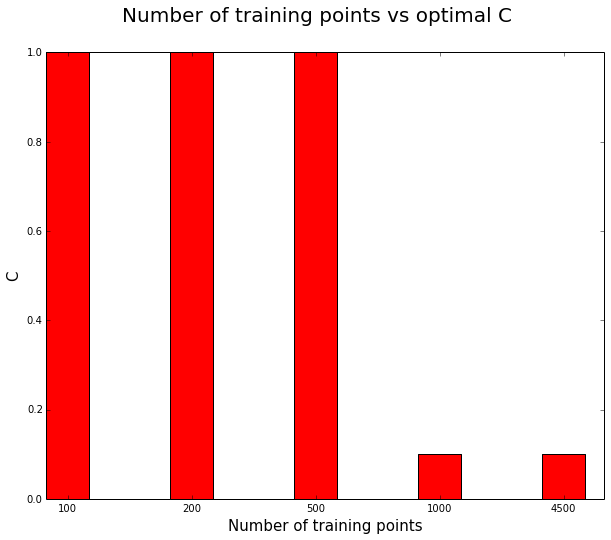

In [71]:
def plot_params(num_train_points_list, Cs):
    bar_indices = np.arange(len(num_train_points_list))
    bar_width = 0.35
    
    fig, ax = plt.subplots(1, figsize=(10, 8))
    fig.suptitle('Number of training points vs optimal C', fontsize=20)
    
    bars = ax.bar(bar_indices, Cs, bar_width, color='r')

    ax.set_xticks(bar_indices + bar_width/2)
    ax.set_xticklabels(num_train_points_list)
    ax.set_xlabel('Number of training points', fontsize=15)
    ax.set_ylabel('C', fontsize=15)    
    plt.show()

plot_params(num_train_points_list, Cs) 

## Problem 2 Analysis

I repeated the experiment of question one four times, varying the number of training sentences to be the first 100, 200, 500, and 1000 sentences in the training data. As the plot above shows, the first three experiments achieved their lowest Hamming loss when C was set to 1.0, while the 1000-sentence experiment achieved its lowest loss with a C of 0.1.

The plot training and testing error for all of these runs is in the first graph above.

## Problem 3 Code

In [157]:
# Problem 3
# Choosing Noun, Adjective, Punctuation

label_list = ['verb', 'noun', 'adj', 'adv', 'prep', 'pro', 'det', 'num', 
              'punc', 'oth']
labels = {label: i for i, label in enumerate(label_list)}

NUM_CLASSES = 10
trans_matrix = np.reshape(prob_one_full_model.w[-NUM_CLASSES*NUM_CLASSES:], 
                          (NUM_CLASSES, NUM_CLASSES))
print 'Noun -> Adjective', trans_matrix[labels['noun']][labels['adj']]
print 'Noun -> Punctuation', trans_matrix[labels['noun']][labels['punc']]
print 'Adjective -> Noun', trans_matrix[labels['adj']][labels['noun']]
print 'Adjective -> Punctuation', trans_matrix[labels['adj']][labels['punc']]
print 'Punctuation -> Noun', trans_matrix[labels['punc']][labels['noun']]
print 'Punctuation -> Adjective', trans_matrix[labels['punc']][labels['adj']]

Noun -> Adjective -0.533145504458
Noun -> Punctuation 0.604025170359
Adjective -> Noun 1.66385486951
Adjective -> Punctuation 0.128287746948
Punctuation -> Noun 0.657357663981
Punctuation -> Adjective -0.323585545421


### Problem 3 Part 1 Discussion

I chose 'noun', 'adjective', and 'punctuation' to be the three parts of speech to analyze. The transition weights between all pairs of these three parts of speech are as follows:

Noun -> Adjective: -0.53. 
  Adjectives never come after nouns in English, so it's correct that this weight is negative.


Noun -> Punctuation: 0.60.
  Sentences may end in nouns, but other types of speech are also likely, so a moderately positive weight makes sense.


Adjective -> Noun: 1.66.
  Adjectives usually precede nouns, so a highly positive weight like this makes sense.


Adjective -> Punctuation: 0.13.
  Sentences only occasionally end in adjectives (e.g. "The building is tall."), so a small positive weight is expected.


Punctuation -> Noun: 0.66.
  Snetences often end with a punctuation mark and begin with a noun, so a positive weight is correct. 


Punctuation -> Adjective: -0.32.
  Sentences rarely, if ever, begin with an adjective, so a negative weight makes sense.

In [158]:
# Problem 3, Part 2

# For each of these three classes, which 10 features have the largest absolute 
# value weights (i.e., contribute the most to the predictions)?
def top_features(model, label_index):
    NUM_CLASSES = 10
    NUM_FEATURES = (len(prob_one_model.w)-NUM_CLASSES**2) / NUM_CLASSES
    start_index = NUM_FEATURES * (label_index)
    features = prob_one_full_model.w[start_index:start_index + NUM_FEATURES]

    with open('ps7_data/prefixes.txt', 'r') as f:
        prefixes = ['prefix-' + line.strip() for line in f]
    with open('ps7_data/suffixes.txt', 'r') as f:
        suffixes = ['suffix-' + line.strip() for line in f]
    feature_labels = np.array(
        ['Bias', 'NoInitCap', 'InitCap', 'NoAllCap', 'AllCap'] + prefixes + suffixes)
    assert len(feature_labels) == num_features, len(feature_labels)

    descending_indices = np.argsort(features)[::-1]
    top_features = feature_labels[descending_indices][:10]
    return top_features


print 'Top Features for nouns:', top_features(prob_one_full_model, labels['noun'])
print 'Top Features for adjectives:', top_features(prob_one_full_model, 
                                                   labels['adj'])
print 'Top Features for punctuation:', top_features(prob_one_full_model,
                                                    labels['punc'])

Top Features for nouns: ['suffix-rs' 'suffix-es' 'suffix-ts' 'suffix-gs' 'suffix-cy' 'suffix-ls'
 'InitCap' 'suffix-ns' 'suffix-ty' 'suffix-ks']
Top Features for adjectives: ['suffix-al' 'suffix-ic' 'prefix-ot' 'suffix-sh' 'suffix-le' 'suffix-rn'
 'suffix-li' 'prefix-la' 'suffix-an' 'suffix-ul']
Top Features for punctuation: ['suffix-"' 'prefix-"' 'prefix-;' 'suffix-;' 'prefix-$' 'suffix-$'
 'prefix--' 'suffix--' 'suffix-.' 'prefix-.']


### Problem 3 Part 2 Analysis

For nouns, the top ten most informative features were nearly all suffixes: "rs", "es", "ts", "gs", "cy", "ls", "ns, "ty", and "ks". All these suffixes are common for nouns since they consist of a consonant and the letter "s", which is often indicative of a plural noun, e.g. "others", "planes", "planets", "things", etc. The suffix "cy" is a surprise for nouns, though, since few nouns end with "cy".
The only non-suffix of the top ten most informative features was when a word begins with a capital letter, which makes sense since proper nouns always start with a capital letter.

The top features for adjectives were all suffixes and prefixes. The most common suffixes where "al", "ic", "sh", "le", "rn", "li", "an", and "ul", as in "regional", "athetic", "selfish", etc. The most common prefixes were "ot" and "la".

The top features for punctuation where all punctuation marks, which of course makes sense. Interestingly, all punctation marks are counted as both prefixes and suffixes in this model, so the top ten features are actually simply the top five most common punctuation marks in the corpus.

## Problem 4 Code
This code prints the first ten test sentences, their parts of speech as predicted by the model from problem 1, and their actual parts of speech.

In [155]:
# Problem 4
X_test_orig_sample = X_test_orig[:10]
X_test_enc_sample = X_test_enc[:10]
y_test_sample = y_test[:10]

predicted_labels = prob_one_full_model.predict(X_test_enc_sample)

zipped_stuff = zip(test_sentences, predicted_labels, y_test_sample)

for i, (sentence, predicted, actual) in enumerate(zipped_stuff):
    assert len(sentence) == len(predicted) == len(actual)
    print 'Sentence', i+1
    for word, p, a in zip(sentence, predicted, actual):
        correct = p == a       
        print '  "%s"' % word
        print '     predicted: "%s", actual: "%s", correct: %s' % (
            label_list[p], label_list[a], correct)


Sentence 1
  "Market-making"
     predicted: "noun", actual: "verb", correct: False
  "in"
     predicted: "prep", actual: "prep", correct: True
  "the"
     predicted: "det", actual: "det", correct: True
  "rarely-traded"
     predicted: "verb", actual: "adj", correct: False
  "FTO"
     predicted: "oth", actual: "noun", correct: False
  "contract"
     predicted: "noun", actual: "noun", correct: True
  "was"
     predicted: "verb", actual: "verb", correct: True
  "expected"
     predicted: "verb", actual: "verb", correct: True
  "to"
     predicted: "oth", actual: "oth", correct: True
  "begin"
     predicted: "verb", actual: "verb", correct: True
  "today"
     predicted: "noun", actual: "noun", correct: True
  ";"
     predicted: "punc", actual: "punc", correct: True
  "but"
     predicted: "oth", actual: "oth", correct: True
  "an"
     predicted: "det", actual: "det", correct: True
  "EOE"
     predicted: "noun", actual: "noun", correct: True
  "spokesman"
     predicted: "noun",